**Introduction:** Schools the world over always have to contend with the problem of students dropping out. Since education is a basic human right, this is naturally an issue both schools and governments want to be able to predict and ideally resolve - no one wants to see a student drop out of school if it can be avoided. The first step to minimizing dropout rates, of course, is to understand the primary motivations for why students leave school behind.

**Objective:** [This dataset](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data), created by the researchers behind [this paper](https://www.mdpi.com/2306-5729/7/11/146), attempts to create a comprehensive view of students enrolled at various undergraduate degree programs at a university. With demographic data, socioeconomic factors, academic performance indicators, and personal student information upon enrollment all accounted for, our goal is to use machine learning to predict what factors contribute to students dropping out the most. We hope to achieve this by building an explainable model that accurately assesses whether or not a given student is likely to be a dropout or not.

### 1. Data Preprocessing:

First, let's import all the necessary libraries and read in the dataset.

In [ ]:
from google.colab import drive
import os
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imb_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
%matplotlib inline
# Enable inline mode for matplotlib so that IPython displays graphs.

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/')

# Read in the data with Pandas
data = pd.read_csv("dataset.csv")
df = pd.DataFrame(data)

# What does this dataset look like?
print(data.shape)
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(4424, 35)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


Now, let's check for missing values in the dataset.

In [ ]:
df = df.rename(columns = {'Nacionality': 'Nationality', 'Age at enrollment': 'Age'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nationality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

Based off of the above information, it's clear that there are no null values, which makes our lives a little easier. In fact, the only non-numeric feature is our label, named Target. Let's look a little deeper into Target:

In [ ]:
df['Target'].value_counts()

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

So Target keeps track of graduates, currently enrolled students, and dropouts. Since our main focus is on classifying dropouts, it makes sense to convert Target into a binary label distinguishing between dropouts and everyone else - it would be counterproductive for our model to attempt to classify currently enrolled students versus graduates, for example.

Thus, we will create a new label, called Dropout, that will take on one of two values - 1 if the student is a dropout, and 0 if the student is either a graduate or currently enrolled in school.

In [ ]:
df['Dropout'] = df['Target'].map(lambda x: 1 if x == 'Dropout' else 0)

# dropping the original label to avoid confusion
df = df.drop(['Target'], axis = 1)

print(df['Dropout'].value_counts())
df.head()

Dropout
0    3003
1    1421
Name: count, dtype: int64


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nationality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Dropout
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,1
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,0
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,1
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,0
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,0


Now we have a label ready for use, but note the imbalance between classes - that is something we will have to account for when modeling.

Next, let's get an idea of the correlation between the various features and the label:

In [ ]:
df.corr()['Dropout']

Marital status                                    0.093712
Application mode                                  0.188908
Application order                                -0.070485
Course                                           -0.000083
Daytime/evening attendance                       -0.080499
Previous qualification                            0.091590
Nationality                                      -0.001571
Mother's qualification                            0.059499
Father's qualification                            0.016267
Mother's occupation                              -0.069102
Father's occupation                              -0.079753
Displaced                                        -0.107232
Educational special needs                         0.002806
Debtor                                            0.229407
Tuition fees up to date                          -0.429149
Gender                                            0.203983
Scholarship holder                               -0.2453

Making this list more readable, we can see which features are strongly correlated with Dropout and which are not:

In [ ]:
df.corr()['Dropout'].abs().sort_values(ascending = False)

Dropout                                           1.000000
Curricular units 2nd sem (grade)                  0.571792
Curricular units 2nd sem (approved)               0.569500
Curricular units 1st sem (grade)                  0.480669
Curricular units 1st sem (approved)               0.479112
Tuition fees up to date                           0.429149
Age                                               0.254215
Scholarship holder                                0.245354
Debtor                                            0.229407
Gender                                            0.203983
Application mode                                  0.188908
Curricular units 2nd sem (evaluations)            0.154999
Curricular units 2nd sem (enrolled)               0.141515
Curricular units 1st sem (enrolled)               0.124635
Displaced                                         0.107232
Marital status                                    0.093712
Previous qualification                            0.0915

We can also view the correlation matrix showing the correlations between all features:

In [ ]:
df.corr()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nationality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Dropout
Marital status,1.000000,0.224855,-0.125854,0.018925,-0.274939,0.120925,-0.020722,0.185522,0.128326,0.069734,...,0.062831,0.039026,0.022784,-0.043739,-0.071506,0.020426,-0.020338,0.008761,-0.027003,0.093712
Application mode,0.224855,1.000000,-0.246497,-0.085116,-0.268616,0.433028,-0.001360,0.092867,0.072798,0.033489,...,0.228973,0.127461,0.164992,-0.065203,-0.104424,0.042009,0.091567,-0.019613,-0.014563,0.188908
Application order,-0.125854,-0.246497,1.000000,0.118928,0.158657,-0.199029,-0.029385,-0.061719,-0.049936,-0.046591,...,-0.125815,0.028878,-0.055089,0.071793,0.055517,-0.015757,-0.098419,-0.011133,0.030201,-0.070485
Course,0.018925,-0.085116,0.118928,1.000000,-0.070232,-0.158382,-0.004761,0.058909,0.045659,0.029672,...,-0.120390,0.185879,0.049236,0.120000,0.178997,-0.013984,-0.050116,0.028775,-0.012518,-0.000083
Daytime/evening attendance,-0.274939,-0.268616,0.158657,-0.070232,1.000000,-0.103022,0.024433,-0.195346,-0.137769,-0.037986,...,-0.111953,0.000371,0.014610,0.034022,0.050493,-0.004229,0.061974,-0.024043,0.022929,-0.080499
Previous qualification,0.120925,0.433028,-0.199029,-0.158382,-0.103022,1.000000,-0.038997,0.018868,0.013152,0.006190,...,0.138463,0.056450,0.101501,-0.037265,-0.038765,0.024186,0.096914,-0.056388,0.053968,0.091590
Nationality,-0.020722,-0.001360,-0.029385,-0.004761,0.024433,-0.038997,1.000000,-0.043847,-0.088892,0.044123,...,-0.000747,-0.020103,-0.018023,-0.014142,-0.005409,-0.012052,-0.006013,-0.012331,0.044563,-0.001571
Mother's qualification,0.185522,0.092867,-0.061719,0.058909,-0.195346,0.018868,-0.043847,1.000000,0.524529,0.295178,...,0.036986,0.033070,0.018874,-0.013161,-0.028472,0.020364,-0.106107,0.056653,-0.079664,0.059499
Father's qualification,0.128326,0.072798,-0.049936,0.045659,-0.137769,0.013152,-0.088892,0.524529,1.000000,0.207067,...,0.041695,0.023635,0.009471,0.006052,-0.006508,-0.008493,-0.075417,0.056661,-0.070200,0.016267
Mother's occupation,0.069734,0.033489,-0.046591,0.029672,-0.037986,0.006190,0.044123,0.295178,0.207067,1.000000,...,-0.002057,0.009287,0.011546,0.022309,0.035230,-0.004903,-0.011772,0.015014,0.091880,-0.069102


There are a lot of features that appear weakly correlated with the target. To reduce dimensionality, we will keep the top 15 features in terms of the strength of their correlation with Dropout to use as predictors for our various models - this essentially keeps every feature with |correlation coefficient| >= 0.1.

In [ ]:
kept_features = ['Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (approved)', 'Curricular units 1st sem (grade)',
                 'Curricular units 1st sem (approved)', 'Tuition fees up to date', 'Age', 'Scholarship holder', 'Debtor',
                 'Gender', 'Application mode', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (enrolled)',
                 'Curricular units 1st sem (enrolled)', 'Displaced', 'Marital status', 'Dropout']
df = df[kept_features]
print(df.shape)
df.head()

(4424, 16)


,Curricular units 2nd sem (grade),Curricular units 2nd sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (approved),Tuition fees up to date,Age,Scholarship holder,Debtor,Gender,Application mode,Curricular units 2nd sem (evaluations),Curricular units 2nd sem (enrolled),Curricular units 1st sem (enrolled),Displaced,Marital status,Dropout
0,0.000000,0,0.000000,0,1,20,0,0,1,8,0,0,0,1,1,1
1,13.666667,6,14.000000,6,0,19,0,0,1,6,6,6,6,1,1,0
2,0.000000,0,0.000000,0,0,19,0,0,1,1,0,6,6,1,1,1
3,12.400000,5,13.428571,6,1,20,0,0,0,8,10,6,6,1,1,0
4,13.000000,6,12.333333,5,1,45,0,0,0,12,6,6,6,0,2,0


### 2. Data Exploration

Before we begin modeling the data, it's important we first understand it.

First, let's start with a basic graph of our label, Dropout:

([<matplotlib.patches.Wedge at 0x7ecd1c65a860>,
 [Text(-0.5858965886360976, 0.9309807664095878, 'Enrolled or Graduate'),
  Text(0.585896675800805, -0.9309807115539862, 'Dropout')],
 [Text(-0.31957995743787143, 0.507807690768866, '67.9%'),
  Text(0.31958000498225725, -0.5078076608476289, '32.1%')])

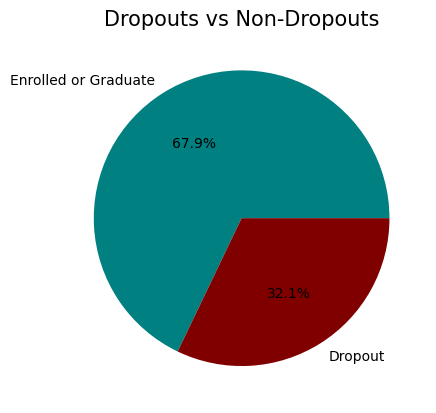

In [ ]:
labels = ['Enrolled or Graduate', 'Dropout']
plt.title('Dropouts vs Non-Dropouts', size=15)
plt.pie(df['Dropout'].value_counts(), autopct="%1.1f%%",labels=labels,colors=['teal', 'maroon'])

Over two-thirds of our data is enrolled students and graduates - a clear imbalance between the two possible classes. To combat this, we will use a technique called SMOTE (Synthetic Minority Oversampling Technique) when modeling to equalize the classes. This will hopefully prevent our models from overfitting to the dataset.

Moving on to the 15 selected features, a few intuitively make sense - those performing poorly in school (measured by the curricular features) are more likely to drop out, as well as those going through financial problems (tuition fees up to date, debtor). In the middle of those features is age, which does not immediately come to mind when thinking of why someone would drop out. Let's plot this relationship to understand it better:

Dropout
0    21.938395
1    26.068966
Name: Age, dtype: float64


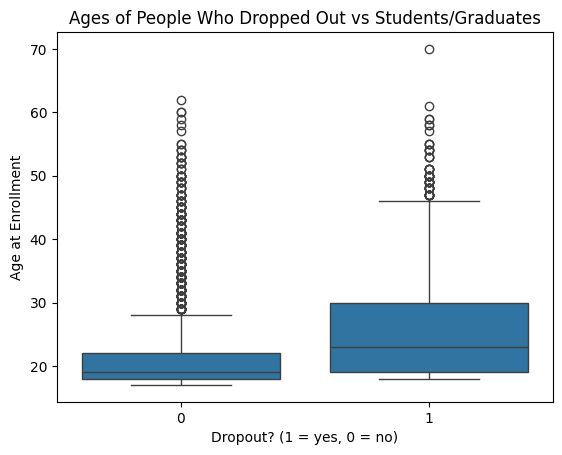

In [ ]:
sns.boxplot(y=df["Age"], x=df["Dropout"])
plt.xlabel('Dropout? (1 = yes, 0 = no)')
plt.ylabel('Age at Enrollment')
plt.title('Ages of People Who Dropped Out vs Students/Graduates')
print(df.groupby('Dropout').mean()['Age'].sort_values())
plt.show()

We can see that those who drop out are, on average, older. This perhaps could be explained by older people having more responsibilities, as well as having a potential job they could fall back on in case college does not go well.

Next, let's explore the application mode and why it could possibly be correlated with the label. From the paper, we have a guide to further enrich our exploration:



<Axes: xlabel='Application mode', ylabel='count'>

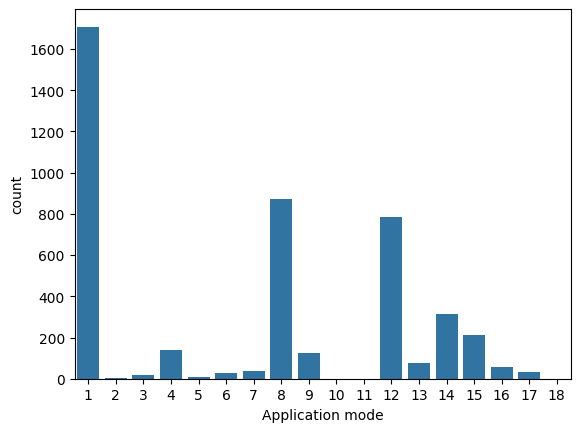

In [ ]:
sns.countplot(x = df['Application mode'])

In [ ]:
pd.crosstab(df['Dropout'], df['Application mode'], margins = True)

Application mode,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,All
Dropout,,,,,,,,,,,,,,,,,,,
0,1363,1,14,54,7,25,33,616,79,0,0,350,43,197,150,39,31,1,3003
1,345,2,2,85,3,5,5,256,45,1,1,435,34,115,63,20,4,0,1421
All,1708,3,16,139,10,30,38,872,124,1,1,785,77,312,213,59,35,1,4424


The most common modes of application for both non-dropouts and overall are 1 (general application, 1st phase), 8 (general application, 2nd phase), 12 (over 23 years old), 14 (change in course), and 15 (technological specialization diploma holders). For dropouts, it's 12 (over 23 years old), 1 (general application, 1st phase), 8 (general application, 2nd phase), 14 (change in course), and 4 (holders of other higher courses).

We can see age playing a role again in that older people appear more likely to drop out. We further see other possible causes for dropping out, most notably that those changing their major or already majoring in another course are at increased risk of dropping out.

Now, to confirm our previous intuition, let's compare the distribution of debtors between dropouts and non-dropouts:

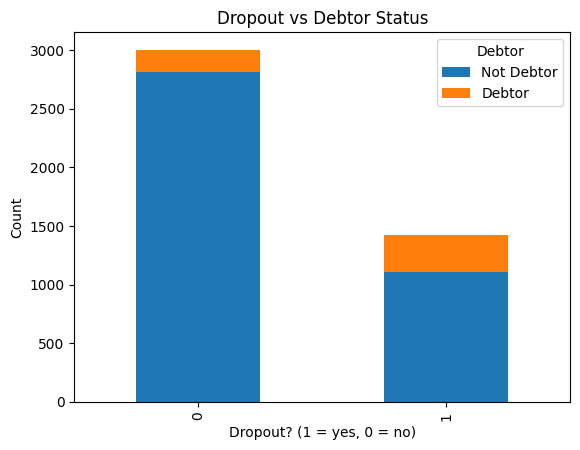

In [ ]:
grouped_counts = df.groupby(['Dropout', 'Debtor']).size().unstack(fill_value=0)
grouped_counts.plot(kind='bar', stacked=True)
plt.xlabel('Dropout? (1 = yes, 0 = no)')
plt.ylabel('Count')
plt.title('Dropout vs Debtor Status')
plt.legend(title='Debtor', labels=['Not Debtor', 'Debtor'])
plt.show()

We see that a higher proportion of dropouts are in debt compared to students and graduates, supporting our intuition that dropouts tend to have more financial trouble.

Finally, let's take a look at the relation between gender and the Dropout label:



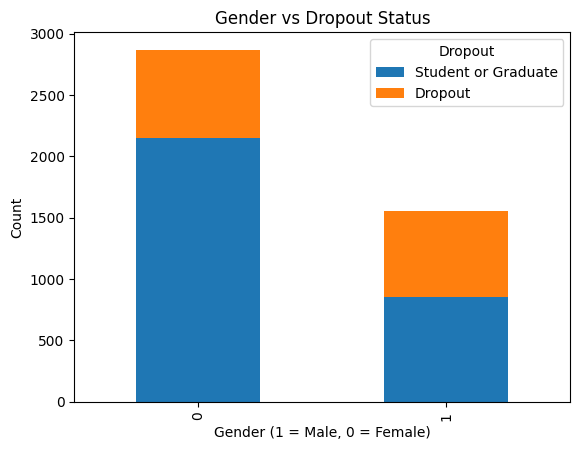

In [ ]:
grouped_counts_gender = df.groupby(['Gender', 'Dropout']).size().unstack(fill_value=0)
grouped_counts_gender.plot(kind='bar', stacked=True)
plt.xlabel('Gender (1 = Male, 0 = Female)')
plt.ylabel('Count')
plt.title('Gender vs Dropout Status')
plt.legend(title='Dropout', labels=['Student or Graduate', 'Dropout'])
plt.show()

Text(0.5, 1.0, 'Gender Distribution Among Dropouts')

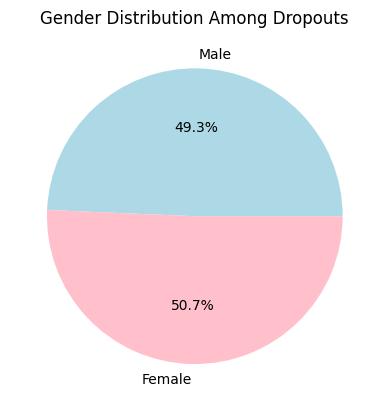

In [ ]:
male_dropouts = df[(df['Gender'] == 1) & (df['Dropout'] == 1)].shape[0]
female_dropouts = df[(df['Gender'] == 0) & (df['Dropout'] == 1)].shape[0]
plt.pie([male_dropouts, female_dropouts], labels = ['Male', 'Female'], autopct = '%1.1f%%', colors = ['lightblue', 'pink'])
plt.title('Gender Distribution Among Dropouts')

We see that the dropouts are evenly split across gender. However, from the first graph, it is evident that there are more women represented in the dataset than men. This indicates that men might be more likely to drop out compared to women.

With the data now cleaned up, explored, and modified according to our purposes, we are ready to begin building models from our data.

### Modeling

Before beginning with modeling, we will first separate our labels (Dropout column) from the rest of the data for ease of use:

In [ ]:
data_Y = df['Dropout']
data_X = df.drop(['Dropout'], axis = 1)

Here, we will try various types of models to determine which one would be most optimal for our dataset. Each model will be run through a 5-fold nested cross-validation loop both to optimize hyperparameters and get a more accurate estimate of the efficacy of our models.

As a binary classification problem, we will mostly try supervised learning algorithms. Within each fold, SMOTE will be applied to ensure balance between dropouts and non-dropouts, potentially improving model performance.

Finally, we will use accuracy as our primary metric for assessing models. Our main concern is with differentiating between dropouts and students/graduates, so accuracy is the best for this purpose. We will also look at recall - from university administrative and governmental perspectives, a false negative (misclassifying a dropout as a student or graduate) carries more severe consequences than a false positive (misclassifying a student or graduate as a dropout). However, the algorithm with the highest accuracy will still be used for our final model.

First, we will try a **decision tree**. The hyperparameters we will evaluate are max_depth and min_samples_leaf to properly fit the model, max_features to introduce a greater degree of randomness in the trees to prevent overfitting, and the criterion.

In [ ]:
params = {
    'clf__max_depth': [5, 10, 15, 20, 50],
    'clf__min_samples_leaf': [5, 10, 15, 20, 50],
    'clf__max_features': [1, 2, 3, 4, 5, 7, 9, 11, 13, 15],
    'clf__criterion': ['gini','entropy']
}

# create an imbalanced pipeline as the model to ensure only training data is oversampled
kf = StratifiedKFold(n_splits = 5)
pipeline = imb_pipeline(steps = [('smote', SMOTE()), ('clf', DecisionTreeClassifier())])
grid_search = GridSearchCV(estimator = pipeline, param_grid = params, scoring = 'accuracy', cv = kf).fit(data_X, data_Y)

# run the outer cross-validation loop
model_dt = grid_search.best_estimator_
y_preds = cross_val_predict(estimator = model_dt, X = data_X, y = data_Y, cv = 5)

print("Best Parameters:", grid_search.best_params_)
print(confusion_matrix(y_true = data_Y, y_pred = y_preds))
print(classification_report(y_true = data_Y, y_pred = y_preds))

Best Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__max_features': 11, 'clf__min_samples_leaf': 5}
[[2671  332]
 [ 331 1090]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3003
           1       0.77      0.77      0.77      1421

    accuracy                           0.85      4424
   macro avg       0.83      0.83      0.83      4424
weighted avg       0.85      0.85      0.85      4424



This model performs well, with accuracy at 85% and a recall of 0.85. As expected, it performs best when predicting non-dropouts (the majority class), but still does respectably in predicting dropouts thanks to the use of SMOTE. If we wanted to emphasize finding dropouts, we could change the scoring parameter of GridSearchCV to maximize recall instead of accuracy.

Next up for the models is **K-Means Clustering**. Here, we will use 2 clusters to classify dropouts and graduate/enrolled students using 5-fold cross validation on our data.

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
cross = cross_val_predict(kmeans, data_X, data_Y, cv = 5)


print(confusion_matrix(y_true = data_Y, y_pred = cross))
print(classification_report(y_true = data_Y, y_pred = cross))

[[2762  241]
 [ 648  773]]
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3003
           1       0.76      0.54      0.63      1421

    accuracy                           0.80      4424
   macro avg       0.79      0.73      0.75      4424
weighted avg       0.79      0.80      0.79      4424



Credit: Angie Beasley, CS363M Assignment 5

Purpose: Visualize K-Means Clustering on our dataset using MDS.
Visually we can see this clustering method will classify all data points into either dropout or graduate/enrolled as two separate groups.


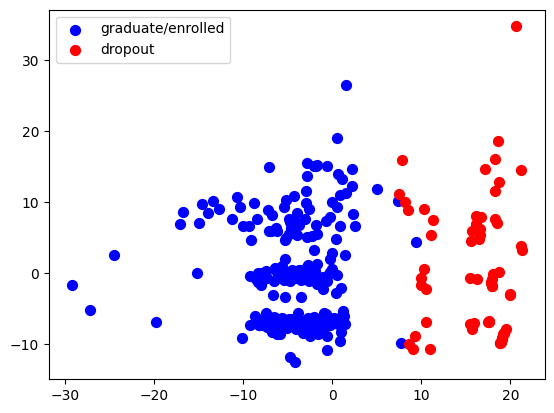

In [ ]:
def scatter(data, labels, numPoints = 300):
    numEntries = data.shape[0]
    start = random.randint(0, numEntries - numPoints)
    end = start + numPoints
    data = data[start:end]
    labels = labels[start:end]

    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(data)
    plt.scatter(mds_data[labels==0, 0], mds_data[labels==0, 1], c='blue', label='graduate/enrolled', s=50)
    plt.scatter(mds_data[labels==1, 0], mds_data[labels==1, 1], c='red', label='dropout', s=50)
    plt.legend()
    plt.show()

scatter(data_X, cross)



Overall, we can see it is fairly accurate (80%) but has a staggeringly low recall of 0.54 for dropouts. This model mainly overfits to the majority students/graduate class, and is a good example of how SMOTE (not used here) helps our models better classify dropouts. That said, as an unsupervised model, it would appear from the scatterplot that the algorithm was able to figure out the difference between dropouts and students/graduates, which is encouraging. However, this model would be unfit for real-world use, simply because it would misclassify too many dropouts as non-dropouts.

Next, we will build a **Naive Bayes** model. This is a simple and fast algorithm that does not require any hyperparameter tuning, so it is worth trying.

In [ ]:
pipeline = imb_pipeline(steps = [('smote', SMOTE()), ('clf', GaussianNB())])
y_preds = cross_val_predict(estimator = pipeline, X = data_X, y = data_Y, cv = 5)

print(confusion_matrix(y_true = data_Y, y_pred = y_preds))
print(classification_report(y_true = data_Y, y_pred = y_preds))

[[2672  331]
 [ 396 1025]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      3003
           1       0.76      0.72      0.74      1421

    accuracy                           0.84      4424
   macro avg       0.81      0.81      0.81      4424
weighted avg       0.83      0.84      0.83      4424



With an accuracy of 83% and recall of 0.83, Naive Bayes also performs well, though it is not as good as the decision tree classifier. It performs notably worse than the decision tree when it comes to classifying dropouts. Verdict: a solid but not spectacular model.

The next model we will build is a **K-Nearest-Neighbor (KNN)** model, which determines the label for records in the test set by looking at the labels of its k nearest neighbors. Note that before running this model, we must scale the data. We will further apply Principal Component Analysis (PCA) to our data to reduce dimensionality, which will ideally improve the performance of the KNN model.

We have two hyperparameters to tune for this model - n_components for PCA, and k, the number of nearest neighbors to consider.

In [ ]:
params = {
    'pca__n_components': list(range(1, 16)),
    'knn__n_neighbors': list(range(1, 26))
}

# create an imbalanced pipeline as the model to ensure only training data is oversampled
kf = StratifiedKFold(n_splits = 5)
pipeline = imb_pipeline(steps = [('smote', SMOTE()), ('scaler', StandardScaler()), ('pca', PCA()),
           ('knn', KNeighborsClassifier())])
grid_search = GridSearchCV(estimator = pipeline, param_grid = params, scoring = 'accuracy', cv = kf).fit(data_X, data_Y)

# run the outer cross-validation loop
model_knn = grid_search.best_estimator_
y_preds = cross_val_predict(estimator = model_knn, X = data_X, y = data_Y, cv = 5)

print("Best Parameters:", grid_search.best_params_)
print(confusion_matrix(y_true = data_Y, y_pred = y_preds))
print(classification_report(y_true = data_Y, y_pred = y_preds))

Best Parameters: {'knn__n_neighbors': 16, 'pca__n_components': 13}
[[2718  285]
 [ 406 1015]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      3003
           1       0.78      0.71      0.75      1421

    accuracy                           0.84      4424
   macro avg       0.83      0.81      0.82      4424
weighted avg       0.84      0.84      0.84      4424



This model has an accuracy of 85% and a recall of 0.85, outperforming Naive Bayes, but note how the precision and recall are lopsided toward the majority non-dropouts category. It's not a terrible model, but due to the affinity for non-dropouts, it risks suffering from overfitting in the real world. It is especially unfit for schools looking to identify potential dropouts due to this fact.

We will now build a **Support Vector Classifier (SVC)**, which attempts to find a hyperplane of best fit that effectively splits the different values of a label with the help of a kernel function and a cost of misclassification C. We will first scale the data, like we did for KNN. We are tuning two hyperparameters - the kernel function to use, and the cost of misclassification C.

In [ ]:
params = {
    'svc__C': [1, 10, 100],
    'svc__kernel': ['linear', 'rbf', 'poly']
}

# create an imbalanced pipeline as the model to ensure only training data is oversampled
kf = StratifiedKFold(n_splits = 5)
pipeline = imb_pipeline(steps = [('smote', SMOTE()), ('scaler', StandardScaler()), ('svc', SVC())])
grid_search = GridSearchCV(estimator = pipeline, param_grid = params, scoring = 'accuracy', cv = kf).fit(data_X, data_Y)

# run the outer cross-validation loop
model_svc = grid_search.best_estimator_
y_preds = cross_val_predict(estimator = model_svc, X = data_X, y = data_Y, cv = 5)

print("Best Parameters:", grid_search.best_params_)
print(confusion_matrix(y_true = data_Y, y_pred = y_preds))
print(classification_report(y_true = data_Y, y_pred = y_preds))

Best Parameters: {'svc__C': 1, 'svc__kernel': 'linear'}
[[2768  235]
 [ 360 1061]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      3003
           1       0.82      0.75      0.78      1421

    accuracy                           0.87      4424
   macro avg       0.85      0.83      0.84      4424
weighted avg       0.86      0.87      0.86      4424



With an accuracy of 87% and recall of 0.87, the SVC is our best-performing model so far. Its only flaw is its marginally low recall score when classifying dropouts, but even that is the second-best result so far, only 0.01 behind the decision tree. It's evident that our SVC does better at minimizing false positives, but by sheer numbers, it is still in the top 2 models so far. Universities might want to retrain this model with an emphasis on recall, though.

Lastly, we will train a **Neural Network**, more specifically a multi-layer perceptron, which takes feature values as inputs to the input layer and propagates them through a series of hidden layers until the output layer is reached, where the results are used to decide the classification. We will be tuning two hyperparameters for this model - hidden_layer_sizes, the number of nodes in each hidden layer, and the activation function, which is applied to a node's output before being sent to the next layer.

In [ ]:
params = {
    'mlp__hidden_layer_sizes': list(range(10, 61, 10)),
    'mlp__activation': ['logistic', 'tanh', 'relu']
}

# create an imbalanced pipeline as the model to ensure only training data is oversampled
kf = StratifiedKFold(n_splits = 5)
pipeline = imb_pipeline(steps = [('smote', SMOTE()), ('scaler', StandardScaler()), ('mlp', MLPClassifier())])
grid_search = GridSearchCV(estimator = pipeline, param_grid = params, scoring = 'accuracy', cv = kf).fit(data_X, data_Y)

# run the outer cross-validation loop
model_mlp = grid_search.best_estimator_
y_preds = cross_val_predict(estimator = model_mlp, X = data_X, y = data_Y, cv = 5)

print("Best Parameters:", grid_search.best_params_)
print(confusion_matrix(y_true = data_Y, y_pred = y_preds))
print(classification_report(y_true = data_Y, y_pred = y_preds))

Best Parameters: {'mlp__activation': 'logistic', 'mlp__hidden_layer_sizes': 60}
[[2705  298]
 [ 311 1110]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3003
           1       0.79      0.78      0.78      1421

    accuracy                           0.86      4424
   macro avg       0.84      0.84      0.84      4424
weighted avg       0.86      0.86      0.86      4424



Like the other models, the neural network performs well in classifying non-dropouts. It is also accurate, with 86% accuracy and a recall of 0.86. Where this model particularly shines is in its precision and recall for dropouts, especially the latter. It is more important to identify all possible dropouts rather than misclassifying a student or graduate, and in that regard, this model performs admirably.

From our testing, we have concluded that the SVC offers the best accuracy possible from our testing with an accuracy of 87%. The neural network offers the best recall for dropouts, which may be more important in certain contexts.

### 4. Results / Conclusion

While exploring the data we found interesting correlations and trends that might help determine the best factors to assess the risk of dropping out.  Overall, almost a third of students in this data set were dropouts.  We found that, overall, dropouts tended to be older and that a higher percentage of dropouts were debtors compared to students that graduated or were graduate students.  We also found that, as a whole, a higher percentage of male students were dropouts compared to female students.  This is consistent with recent studies that show that "females outperform males in almost all disciplines at various levels of the educational ladder" (Grant and Behrman 2010; Tshabalala and Ncube 2016; Morita et al.).  In addition, the value of a college degree has been declining in recent years, with the percentage of U.S. adults ages 18 to 29 who view college education as “very important” dropping from 74% to 41% in just six years (Gallup).

Overall, the SVC model displayed the highest accuracy for predicting dropouts (87%). One very close contender to SVC is the Neural Network model (86%). Though this is a close call, we would use Neural Networks as our final model, the main reason being the model having better individual recall for dropouts, which we see as more relevant in the real world.